### Transfer Learning and Fine-tuning with Keras and TensorFlow

This tutorial shows you how to leverage a pre-trained network to classify the flower classes that we we classified in the previous notebook 6.a.

A pre-trained network is a network that has already been trained on a large dataset, usually for a large-scale image-classification task. You can use the pre-trained network as it is or customize it for your own task.

The idea of transfer learning for image classification is that a network trained on a large and general dataset can act as a generic model of the visual world. You can then use the features learned by this network to classify new images without having to train a large network from scratch.

In this notebook, we will explore two ways to customize a pre-trained network:

Feature Extraction: Use the features learned by a previous network to extract meaningful features from new images. You just add a new classifier on top of the pre-trained network and train it from scratch for your dataset.

You don't need to train the whole network again. The base convolutional network already has features that are useful for classifying images. But the final classification layer of the pre-trained network is specific to the original task and the classes it was trained on.

Fine-Tuning: Unfreeze some of the top layers of a frozen model base and train both the new classifier layers and the last layers of the base model together. This lets you "fine-tune" the higher-level features in the base model for your specific task.

Transfer learning and fine-tuning are powerful techniques for improving the performance of deep learning models, especially when the data is scarce or expensive to obtain. They allow us to leverage the knowledge learned by a model on a large and general dataset and apply it to a new and related task.

The advantages of transfer learning and fine-tuning over training from scratch are:

- They can save time and computational resources, as they do not require training a large model from scratch.
- They can achieve better results, as they can benefit from the features learned by the pre-trained model that are relevant for the new task.
- They can avoid overfitting, as they can regularize the model by using the pre-trained weights as a prior.

Let's see how we can use it to improve the performance of our flower classifier.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import tensorflow
from tensorflow import keras

### Get the dataset

We will get the dataset as we did in the previous notebook.

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### Create a dataset

In [4]:
batch_size = 32
IMG_SIZE = (160, 160)

As we did before, we'll 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=143,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=143,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Let's have a look at the training batch and labels in our training dataset.

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


### Standardize the data

 Similar to what we did previously, we will rescale the image pixel values but from [0, 255] to [0, 1] this time using `tf.keras.layers.Rescaling`.

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)

We will implement data augmentation using Keras preprocessing layers.

In [10]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ]
)

### Create the base model from the pre-trained convnets

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories. This base of knowledge will help us classify flowers from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [13]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.

In [16]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = normalization_layer(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

The 2.5 million parameters in MobileNet are frozen, but there are 6405 _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [20]:
len(model.trainable_variables)

2

### Train the model

Let's train for 20 epochs. We will get ~87% accuracy on the validation set, with at least ~10% improvement over our previous.

In [21]:
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds)

Epoch 1/20
92/92 [==============================] - 9s 52ms/step - loss: 1.8467 - accuracy: 0.2800 - val_loss: 1.4022 - val_accuracy: 0.4401
Epoch 2/20
92/92 [==============================] - 5s 47ms/step - loss: 1.3241 - accuracy: 0.4683 - val_loss: 1.0803 - val_accuracy: 0.5954
Epoch 3/20
92/92 [==============================] - 5s 45ms/step - loss: 1.0474 - accuracy: 0.5957 - val_loss: 0.8917 - val_accuracy: 0.6921
Epoch 4/20
92/92 [==============================] - 4s 39ms/step - loss: 0.9051 - accuracy: 0.6540 - val_loss: 0.7763 - val_accuracy: 0.7384
Epoch 5/20
92/92 [==============================] - 4s 37ms/step - loss: 0.8060 - accuracy: 0.6989 - val_loss: 0.6915 - val_accuracy: 0.7684
Epoch 6/20
92/92 [==============================] - 3s 35ms/step - loss: 0.7253 - accuracy: 0.7275 - val_loss: 0.6318 - val_accuracy: 0.7929
Epoch 7/20
92/92 [==============================] - 4s 38ms/step - loss: 0.6659 - accuracy: 0.7681 - val_loss: 0.5917 - val_accuracy: 0.8106
Epoch 8/20
92

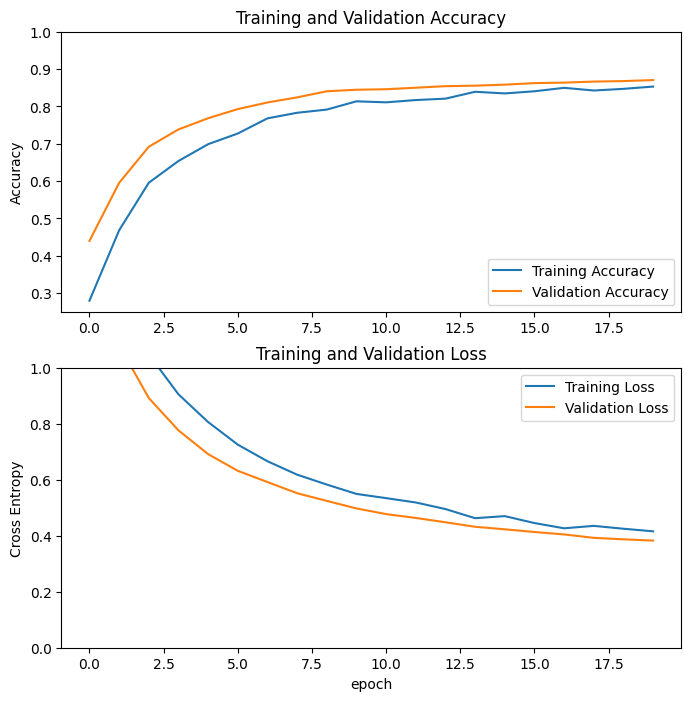

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


compile the model as before, but thi time ss you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [28]:
len(model.trainable_variables)

56

Continue training the model for an additional 10 epochs, this step will improve your accuracy by a few percentage points.

In [30]:
history_fine = model.fit(train_ds,
                         epochs=30,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
92/92 [==============================] - 4s 46ms/step - loss: 0.3245 - accuracy: 0.8822 - val_loss: 0.2939 - val_accuracy: 0.8937
Epoch 21/30
92/92 [==============================] - 4s 44ms/step - loss: 0.2786 - accuracy: 0.8944 - val_loss: 0.2617 - val_accuracy: 0.9019
Epoch 22/30
92/92 [==============================] - 4s 45ms/step - loss: 0.2485 - accuracy: 0.9111 - val_loss: 0.2747 - val_accuracy: 0.8965
Epoch 23/30
92/92 [==============================] - 4s 46ms/step - loss: 0.2395 - accuracy: 0.9145 - val_loss: 0.2301 - val_accuracy: 0.9101
Epoch 24/30
92/92 [==============================] - 4s 45ms/step - loss: 0.2114 - accuracy: 0.9254 - val_loss: 0.2447 - val_accuracy: 0.9074
Epoch 25/30
92/92 [==============================] - 5s 47ms/step - loss: 0.2006 - accuracy: 0.9275 - val_loss: 0.2100 - val_accuracy: 0.9142
Epoch 26/30
92/92 [==============================] - 4s 45ms/step - loss: 0.1850 - accuracy: 0.9332 - val_loss: 0.2018 - val_accuracy: 0.9155
Epoch 

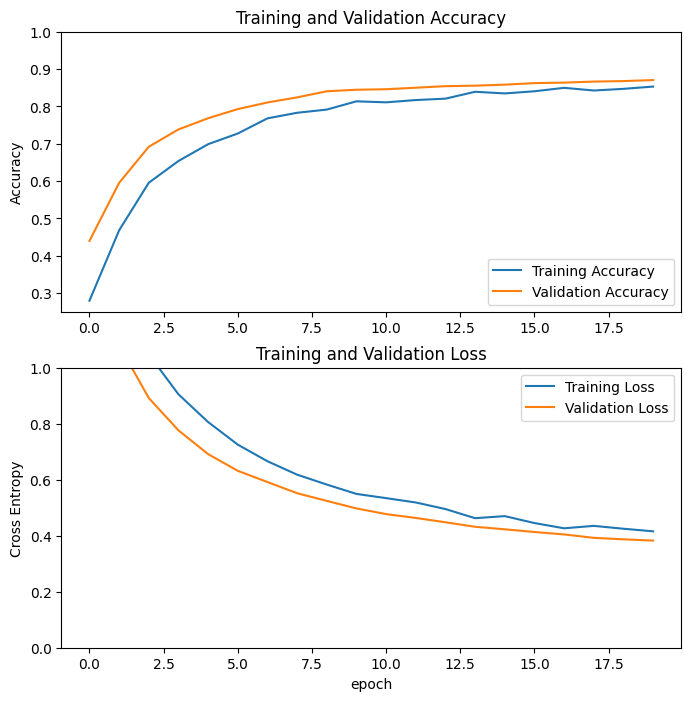

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).